# RTF Model for predicting position with MFCC - Vibrations

Import

In [51]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.fftpack import dct

ReadCsv function

In [52]:
def readCsvFolder(folderPath):
    fileFolder = []
    files = []
    for filepath in glob.glob(os.path.join(folderPath, '*.csv')):
        try:
            data = pd.read_csv(filepath, header=None)  # On suppose pas d'en-têtes
            fileFolder.append(data)
            files.append(os.path.basename(filepath))
        except Exception as e:
            print(f"Erreur lors de la lecture de {filepath} : {e}")
    return fileFolder, files

# Lecture des fichiers
csv_data_list, filenames = readCsvFolder("./Users/vincentdamery/Desktop/projet_vibration/ModelMLAgeRacket/Data_Clean/Chanel0_Data_Columns/P1_clean")



Spectrum

In [53]:
def spectrumFromCsv(csv_data, sample_rate):
    """Calcule le spectre à partir d'un signal CSV"""
    signal = csv_data.iloc[:, 0].values  # extrait la colonne souhaitée
    spectrum = fft(signal)
    magnitude = abs(spectrum[:len(spectrum) // 2])
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)[:len(spectrum) // 2]
    return freqs, magnitude

sample_rate = 20000

spectrumVect = []

for csv_data in csv_data_list:
    freqs, spectrum = spectrumFromCsv(csv_data, sample_rate)
    # Filtrage de la bande [150 Hz, 1000 Hz]
    band_mask = (freqs >= 150) & (freqs <= 1000)
    filtered_freqs = freqs[band_mask]
    filtered_spectrum = spectrum[band_mask]
    spectrumVect.append((filtered_freqs, filtered_spectrum))


# Visualisation des spectres pour les données CSV
for idx, (freqs, spectrum) in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs, spectrum)
    plt.title(f"Spectrum {idx + 1} (CSV Data)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Extract each peak and store

In [54]:
def extractNPeak(n_peak,signal):
    # Find peaks in the signal
    peaks = np.argsort(signal)[-n_peak:]  # Get indices of the n largest peaks
    peaks = np.sort(peaks)  # Sort the indices in ascending order

    # Extract the peak values
    peak_values = signal[peaks]

    return peaks, peak_values


# Fonction pour lire les fichiers d'un dossier donné
def lire_fichiers_dossier(dossier):
    if os.path.exists(dossier):  # Vérifier si le dossier existe
        return readCsvFolder(dossier)
    else:
        print(f"Dossier introuvable : {dossier}")
        return [], [], []  # Retourne des listes vides si le dossier n'existe pas
    
def compute_mfcc(csv_file, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=40):
    # Step 1: Compute the power spectrum
    window = np.hanning(n_fft)
    frames = [
        csv_file[i:i + n_fft] * window
        for i in range(0, len(csv_file) - n_fft, hop_length)
    ]
    power_spectrum = np.array([np.abs(np.fft.rfft(frame))**2 for frame in frames])

    # Step 2: Compute the Mel filterbank
    mel_filters = np.zeros((n_mels, n_fft // 2 + 1))
    mel_min = 0
    mel_max = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin_points = np.floor((n_fft + 1) * hz_points / sample_rate).astype(int)

    for i in range(1, n_mels + 1):
        mel_filters[i - 1, bin_points[i - 1]:bin_points[i]] = (
            np.linspace(0, 1, bin_points[i] - bin_points[i - 1])
        )
        mel_filters[i - 1, bin_points[i]:bin_points[i + 1]] = (
            np.linspace(1, 0, bin_points[i + 1] - bin_points[i])
        )

    # Step 3: Apply the Mel filterbank to the power spectrum
    mel_spectrum = np.dot(power_spectrum, mel_filters.T)

    # Step 4: Take the logarithm of the Mel spectrum
    log_mel_spectrum = np.log(mel_spectrum + 1e-10)

    # Step 5: Compute the DCT to get MFCCs
    mfccs = dct(log_mel_spectrum, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

In [60]:
# Liste des types de raquettes
raquetteTypeList = {"RB": 0, "RO": 1, "RR": 2, "RV": 3}
zones = ["C", "S", "V"]

allCsvFile=[]
allCsvFileLabel=[]

results = []

allCsvFileP1 = []

# Fonction pour lire les fichiers .csv dans un dossier
def readCsvFolder(folder_path):
    files = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            files.append(os.path.join(folder_path, filename))
    return files

# Charger les fichiers P1
for raquetteType in raquetteTypeList:
    fileFolderP1 = readCsvFolder(f"/Users/vincentdamery/Desktop/projet_vibration/ModelMLAgeRacket/Data_Clean/Chanel0_Data_Columns/P1_clean/{raquetteType}")
    allCsvFileP1.extend(fileFolderP1)

print("Len(allCsvFileP1)", len(allCsvFileP1))

# Récupérer les labels en inspectant le nom du fichier
for i in range(len(allCsvFileP1)):
    file_path = allCsvFileP1[i]
    file_name = os.path.basename(file_path)

    # Détection simple de la zone d'impact
    if 'C' in file_name:
        zone = 'C'
    elif 'S' in file_name:
        zone = 'S'
    elif 'V' in file_name:
        zone = 'V'


    allCsvFile.append(file_path)
    allCsvFileLabel.append(f"{zone}")


Len(allCsvFileP1) 208


In [61]:
mfcc_features = []

for csvFile in allCsvFile:
        # Compute the spectrum using FFT
        df = pd.read_csv(csvFile)
        signal = df.iloc[:, 0].values
        # On prend la première colonne de chaque fichier
        mfccs = compute_mfcc(signal, sample_rate)  # Calcul des MFCC

        # Ajouter les MFCC calculés à la liste des caractéristiques
        mfcc_features.append(mfccs.flatten())  # Aplatir les MFCC pour avoir un vecteur d'entrée

In [62]:

    # Combiner les caractéristiques MFCC dans X
X = np.array(mfcc_features)

    # Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allCsvFileLabel)

    # Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

In [63]:
 # Définir les bonnes valeurs trouvé
n_estimators_range = [10, 50, 100]
max_depth_range = [None, 10, 20, 30]
min_samples_split_range = [2, 5, 10]

    # Tester toutes les combinaisons d'hyperparamètres
for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            for min_samples_split in min_samples_split_range:
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42
                )
                rf.fit(X_train, y_train)
                # Évaluer sur l'ensemble de test
                y_pred = rf.predict(X_test)
                accuracy_test = accuracy_score(y_test, y_pred)

                # Évaluer sur l'ensemble d'entraînement
                y_train_pred = rf.predict(X_train)
                accuracy_train = accuracy_score(y_train, y_train_pred)

                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'accuracy_train': accuracy_train,
                    'accuracy_test': accuracy_test
                })
                
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Enregistrer les résultats dans un fichier Excel
#results_df.to_excel("V_RTF_Age_P1.P2.P3_MFCC.xlsx", index=False)

#print("Results have been saved to 'V_RTF_Age_P1.P2.P3_MFCC.xlsx'.")
      
# Trier les résultats par ordre décroissant de 'accuracy_test'
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)

    n_estimators  max_depth  min_samples_split  accuracy_train  accuracy_test
0             10        NaN                  2        1.000000       1.000000
1             10        NaN                  5        1.000000       1.000000
20            50       20.0                 10        1.000000       1.000000
21            50       30.0                  2        1.000000       1.000000
22            50       30.0                  5        1.000000       1.000000
23            50       30.0                 10        1.000000       1.000000
24           100        NaN                  2        1.000000       1.000000
25           100        NaN                  5        1.000000       1.000000
26           100        NaN                 10        1.000000       1.000000
27           100       10.0                  2        1.000000       1.000000
28           100       10.0                  5        1.000000       1.000000
29           100       10.0                 10        1.000000  

## Main

In [65]:
# Liste des types de raquettes
raquetteTypeList = {"RB": 0, "RO": 1, "RR": 2, "RV": 3}
zones = ["C", "S", "V"]

allCsvFile=[]
allCsvFileLabel=[]

results = []

allCsvFileP1 = []

# Fonction pour lire les fichiers .csv dans un dossier
def readCsvFolder(folder_path):
    files = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            files.append(os.path.join(folder_path, filename))
    return files

# Charger les fichiers P1
for raquetteType in raquetteTypeList:
    fileFolderP1 = readCsvFolder(f"/Users/vincentdamery/Desktop/projet_vibration/ModelMLAgeRacket/Data_Clean/Chanel0_Data_Columns/P1_clean/{raquetteType}")
    allCsvFileP1.extend(fileFolderP1)

print("Len(allCsvFileP1)", len(allCsvFileP1))

# Récupérer les labels en inspectant le nom du fichier
for i in range(len(allCsvFileP1)):
    file_path = allCsvFileP1[i]
    file_name = os.path.basename(file_path)

    # Détection simple de la zone d'impact
    if 'C' in file_name:
        zone = 'C'
    elif 'S' in file_name:
        zone = 'S'
    elif 'V' in file_name:
        zone = 'V'


    allCsvFile.append(file_path)
    allCsvFileLabel.append(f"{zone}")

    
for bd in range(10,101,5):

    mfcc_features = []

    for csvFile in allCsvFile:
        # Compute the spectrum using FFT
        df = pd.read_csv(csvFile)
        signal = df.iloc[:, 0].values
        # On prend la première colonne de chaque fichier
        mfccs = compute_mfcc(signal, sample_rate)  # Calcul des MFCC

        # Ajouter les MFCC calculés à la liste des caractéristiques
        mfcc_features.append(mfccs.flatten())  # Aplatir les MFCC pour avoir un vecteur d'entrée
    
    # Combiner les caractéristiques MFCC dans X
    X = np.array(mfcc_features)

    # Encode string labels into integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(allCsvFileLabel)

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    


# Définir les bonnes valeurs trouvé
n_estimators_range = [10, 50, 100]
max_depth_range = [None, 10, 20, 30]
min_samples_split_range = [2, 5, 10]

    # Tester toutes les combinaisons d'hyperparamètres
for n_estimators in n_estimators_range:
        for max_depth in max_depth_range:
            for min_samples_split in min_samples_split_range:
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    random_state=42
                )
                rf.fit(X_train, y_train)
                # Évaluer sur l'ensemble de test
                y_pred = rf.predict(X_test)
                accuracy_test = accuracy_score(y_test, y_pred)

                # Évaluer sur l'ensemble d'entraînement
                y_train_pred = rf.predict(X_train)
                accuracy_train = accuracy_score(y_train, y_train_pred)

                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'accuracy_train': accuracy_train,
                    'accuracy_test': accuracy_test
                })
                
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Enregistrer les résultats dans un fichier Excel
results_df.to_excel("V_RTF_Age_P1.P2.P3_MFCC.xlsx", index=False)

print("Results have been saved to 'V_RTF_Age_P1.P2.P3_MFCC.xlsx'.")
      
# Trier les résultats par ordre décroissant de 'accuracy_test'
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)

Len(allCsvFileP1) 208
Results have been saved to 'V_RTF_Age_P1.P2.P3_MFCC.xlsx'.
    n_estimators  max_depth  min_samples_split  accuracy_train  accuracy_test
0             10        NaN                  2        1.000000       1.000000
1             10        NaN                  5        1.000000       1.000000
20            50       20.0                 10        1.000000       1.000000
21            50       30.0                  2        1.000000       1.000000
22            50       30.0                  5        1.000000       1.000000
23            50       30.0                 10        1.000000       1.000000
24           100        NaN                  2        1.000000       1.000000
25           100        NaN                  5        1.000000       1.000000
26           100        NaN                 10        1.000000       1.000000
27           100       10.0                  2        1.000000       1.000000
28           100       10.0                  5        1.00000

Extract peaks

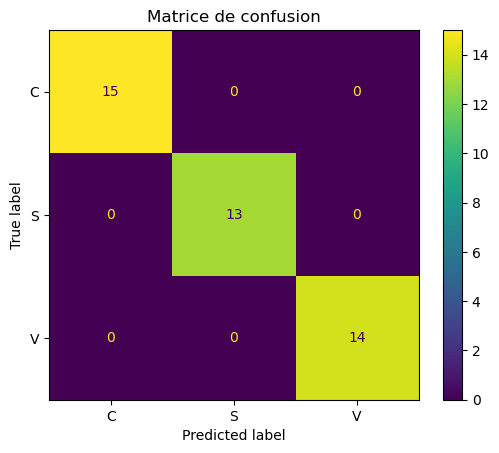

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()